## To skoler statistikere:

- Frekvens eller hyppigheds tilgangen (Standard) $p\sim\frac{x}{n}$
- Bayesian

 # Bayesian
 
 Der kan arbejdes med reasoning med bagrund i hypotheser (propositioner har sandsynligheder)
 priori belifes -> experiment -> opdatere belifes
 
 #### Grundlag Bayes theorem:
 
 $$ P(A|B)P(B) = P(B|A)P(A)$$
 
Sandsynligheden for at være syge, givet man er mand; ganget sandsynligheden for mand. Er lig: sandsynligheden for at være mand, givet man er syg; ganget sandsynligheden for syg.
 
 |   | mand | kvinde|
 |---|------|-------|
 | syg| 19 | 23 | 42
 | ikke| 289| 302 | 591
 |   |308 | 325 | 633
 
 $$ \frac{19}{308}\frac{308}{633} = \frac{19}{42}\frac{42}{633} $$
 
 
 
 Dvs hvis vi har en priori viden om $P(A)$ og laver et experiment med udfald $B$ kan 
 vores viden om A opdateres:
 
 $$ P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$
 
 Hvor sandsynlighederne på højre side komer fra priori belifes og Venstre side er postior

# Kalmanfilter

Modellen har to lag: Det vi måler $z_t$ og en ikke målelig state variable $x_t$. Vi forventer en udvikling i state variable $x_t$ og ens sammenhæng til måling med en forudsigelse af $z_t$ med $y_t(x_t)$. I en linærudgave ser der sådan ud:

$$ x_{t+1} = Ax_t + \epsilon_t $$ 

$$ y_t = Hx_t + \nu_t $$ 

$$ \epsilon \sim N(0,Q)$$ 

$$ \nu \sim N(0,R) $$

In [1]:
step = function(Kal,measured, control_vector=0){
  with(Kal,{ 
   #-----------------Prediction step----------------------------- 
    predicted_state_estimate = A %*% x_hat + B %*% control_vector 
    predicted_prob_estimate = (A %*% P_hat) %*% t(A) + Q 
    #-------------------Observation step--------------------------- 
    innovation = measured - H %*% predicted_state_estimate 
    innovation_covariance = H %*% predicted_prob_estimate%*%t(H) + R
    #-------------------Update step------------------------------- 
    kalman_gain = predicted_prob_estimate %*% t(H) %*% solve(innovation_covariance) 
    current_state_estimate = predicted_state_estimate + kalman_gain %*% innovation
    current_prob_estimate = (diag(1,1)-kalman_gain %*% H) %*% predicted_prob_estimate
    Kal$x_hat = current_state_estimate 
    Kal$P_hat = current_prob_estimate 
    return(Kal) 
  }) 
}

## Voltage mesurement

Simulation af volt målinger, måling er $N(V,\sigma^2)$. Målingerne foretages med jævne mellemrum og vi prøver at finde det rigtige midelværdi. Vi sætter $V=1.25$ og $\sigma=0.25$.

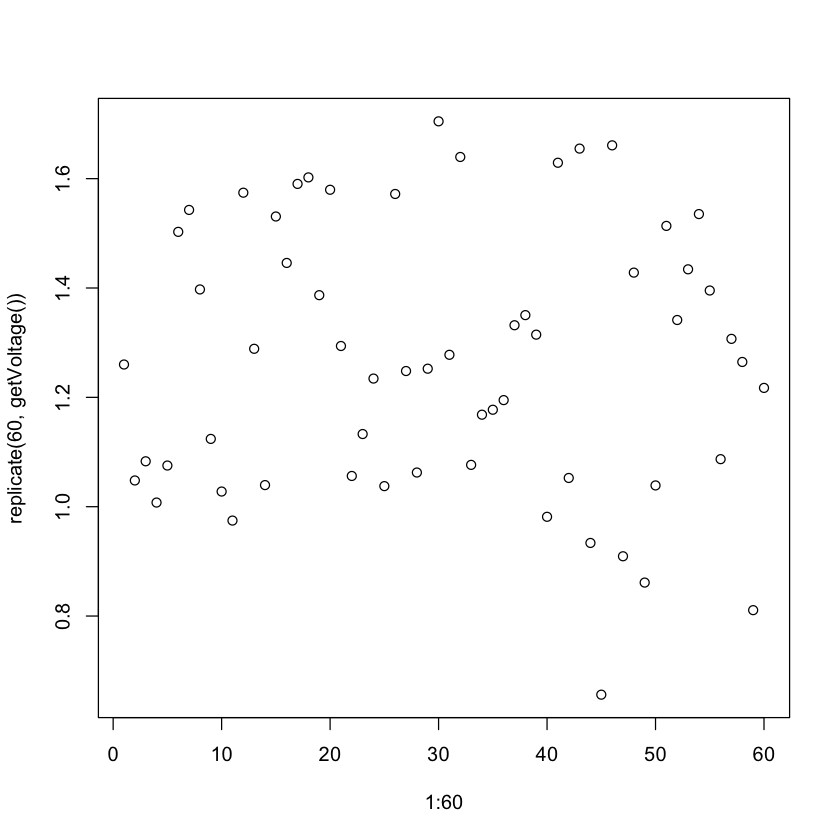

In [2]:
getVoltage = function() rnorm(1,mean=1.25,sd=0.25) 
plot(1:60,replicate(60,getVoltage()))

Her vores state variable er midelværdien omkring målingen, og den forvenets stationær. Dvs $A=1$ Vi forvente også i midel at måle den rigtige værdi dvs $H=1$.

In [3]:
Kal = list(A = matrix(1,1,1), B = matrix(0,1,1), H = matrix(1,1,1), x_hat
= matrix(3,1,1), P_hat = matrix(1,1,1), Q = matrix(0.00001,1,1), R =
matrix(0.1,1,1))
Kal

1
0
1
3
1
1e-05
0.1


In [4]:
n=60

dat = data.frame(messuredvotage=rep(NA,n),kalman=rep(NA,n))
for (i in 1:n){ 
  measured = getVoltage() 
  dat[i,] = c(matrix(measured,1,1),Kal$x_hat) 
  Kal = step(Kal,measured) 
} 

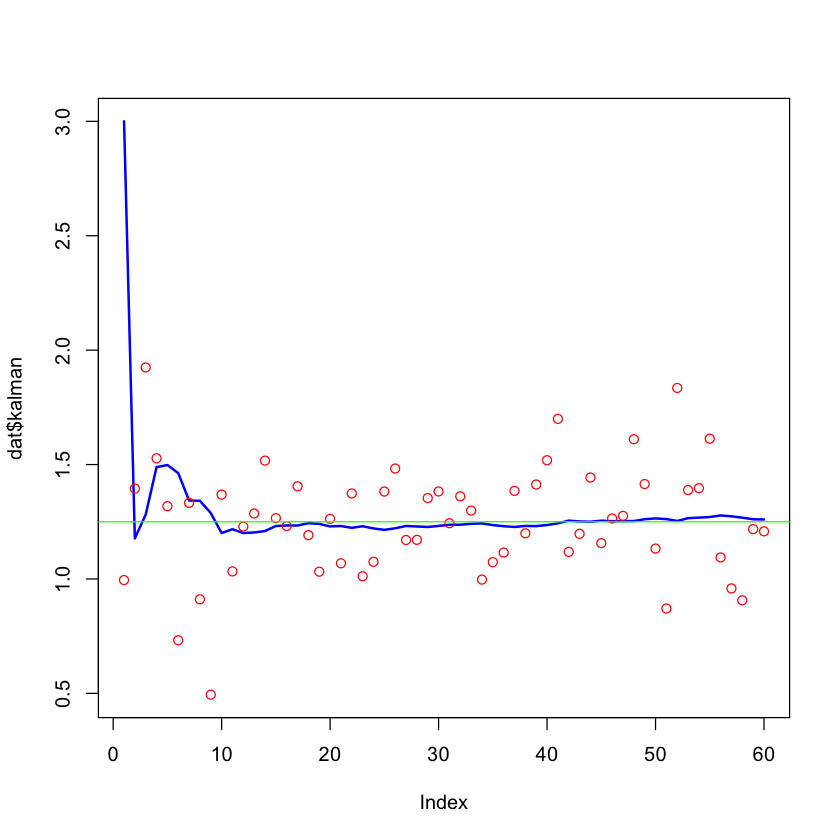

In [5]:
plot(dat$kalman, type='l', ylim = range(c(dat$kalman,dat$messuredvotage)), col='blue', lwd=2) 
points(dat$messuredvotage,col='red') 
abline(h=1.25, col='green') 

Lad os nu prøve at tilstand ændre sig efter 40 step den går fra 1.25 til 1.5. Her er en justerimg af $Q$ vigt
g for at få den nødvendige reponse

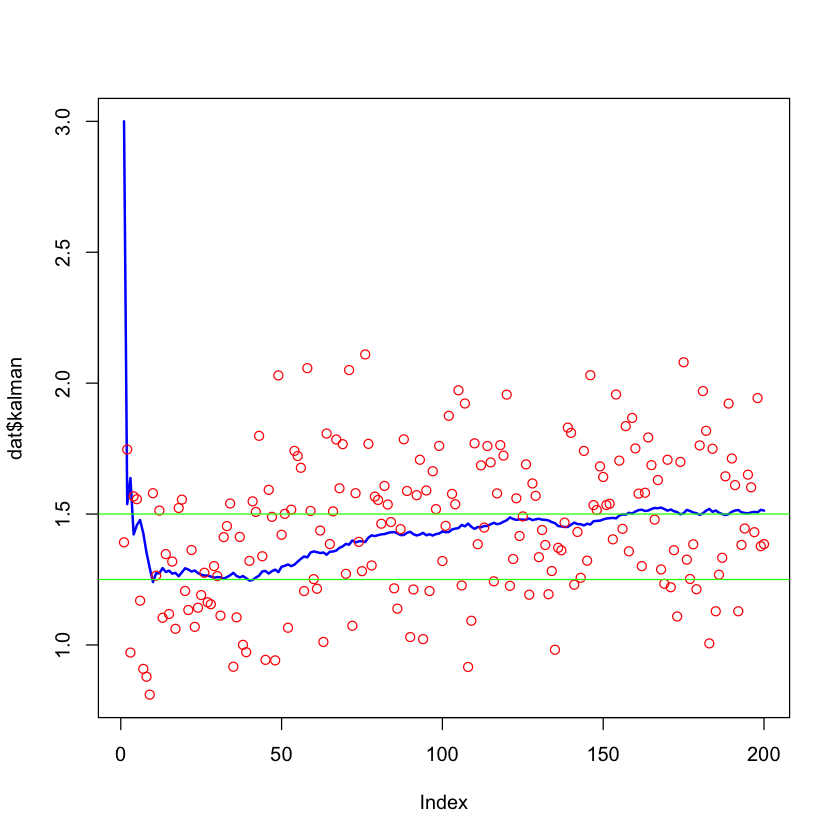

In [6]:
getVoltage = function(t) rnorm(1,mean=ifelse(t <= 40,1.25,1.5),sd=0.25) 
    
Kal = list(A = matrix(1,1,1), B = matrix(0,1,1), H = matrix(1,1,1), x_hat
= matrix(3,1,1), P_hat = matrix(1,1,1), Q = matrix(0.00005,1,1), R =
matrix(0.1,1,1))    
    
n=200
dat = data.frame(messuredvotage=rep(NA,n),kalman=rep(NA,n))
for (i in 1:n){ 
  measured = getVoltage(i) 
  dat[i,] = c(matrix(measured,1,1),Kal$x_hat) 
  Kal = step(Kal,measured) 
} 
    
plot(dat$kalman, type='l', ylim = range(c(dat$kalman,dat$messuredvotage)), col='blue', lwd=2) 
points(dat$messuredvotage,col='red') 
abline(h=1.25, col='green') 
abline(h=1.5, col='green') 

# More Kalman filter

Først laver vi noget data der er noget svær at finde ud af 

In [7]:
t=0:200 
a = 1 - t/100 
x=t %% 12 + t/100 + rnorm(length(t),sd = 0.5) 
y= (x + rnorm(length(x),sd=0.2))*a/5 

Vi har nu en tidsvarierende $x$ (en værdi vi kender/kontrolerer)

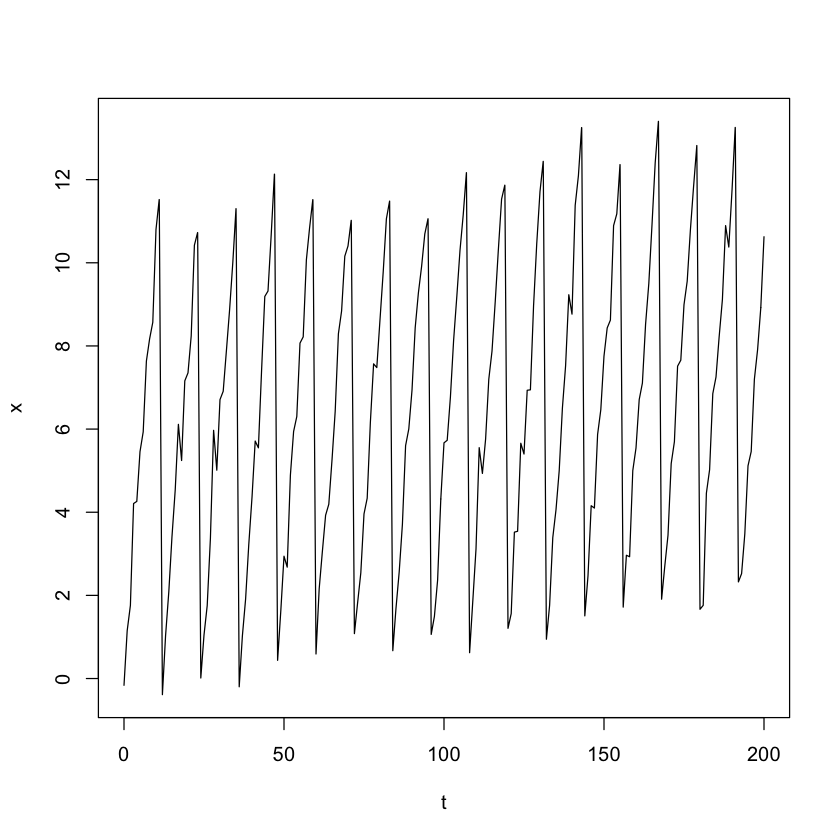

In [8]:
plot(t,x,type='l') 

Og en $y$ som på en eller anden måde er afhængig af $x$

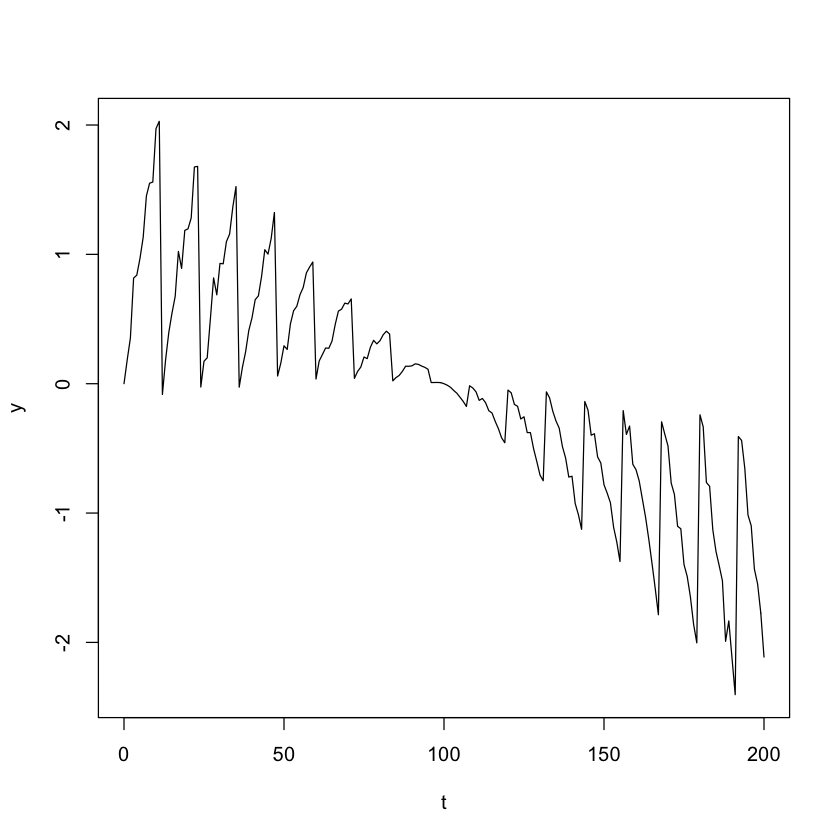

In [9]:
plot(t,y,type='l')

Der er en correlation mellem $x$ og $y$


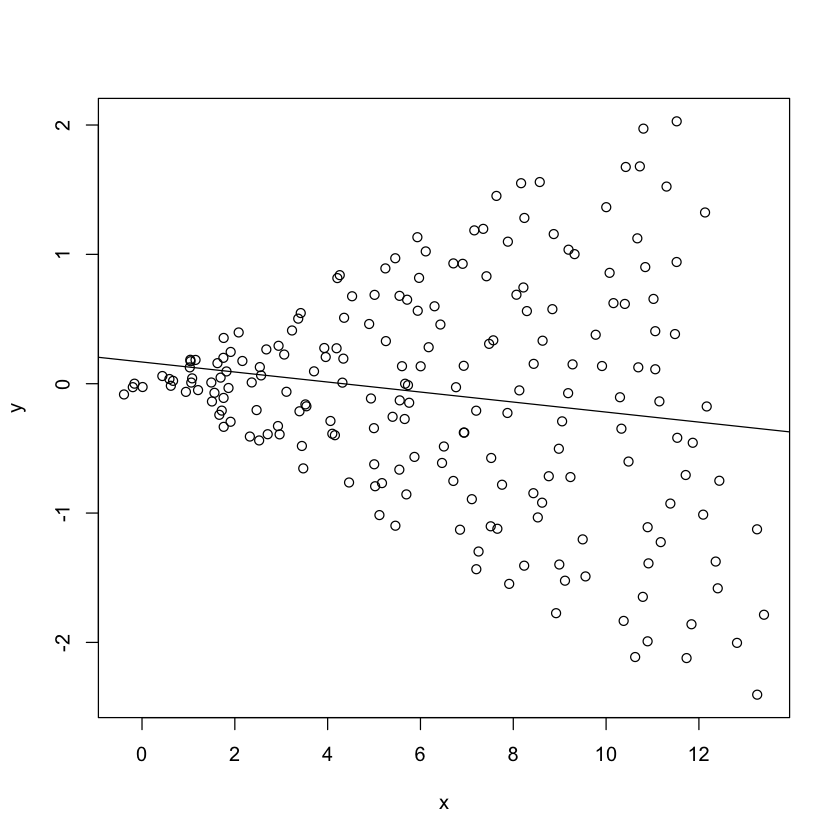

In [10]:
plot(x,y) 
abline(lm(y~x)) 

En simpel regession er måske ikke det rigtige

In [11]:
m = lm(y~x) 
summary(m) 



Call:
lm(formula = y ~ x)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.05863 -0.48653 -0.08926  0.49876  2.30664 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.16808    0.12240   1.373   0.1712  
x           -0.03873    0.01659  -2.334   0.0206 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8388 on 199 degrees of freedom
Multiple R-squared:  0.02665,	Adjusted R-squared:  0.02176 
F-statistic: 5.449 on 1 and 199 DF,  p-value: 0.02058


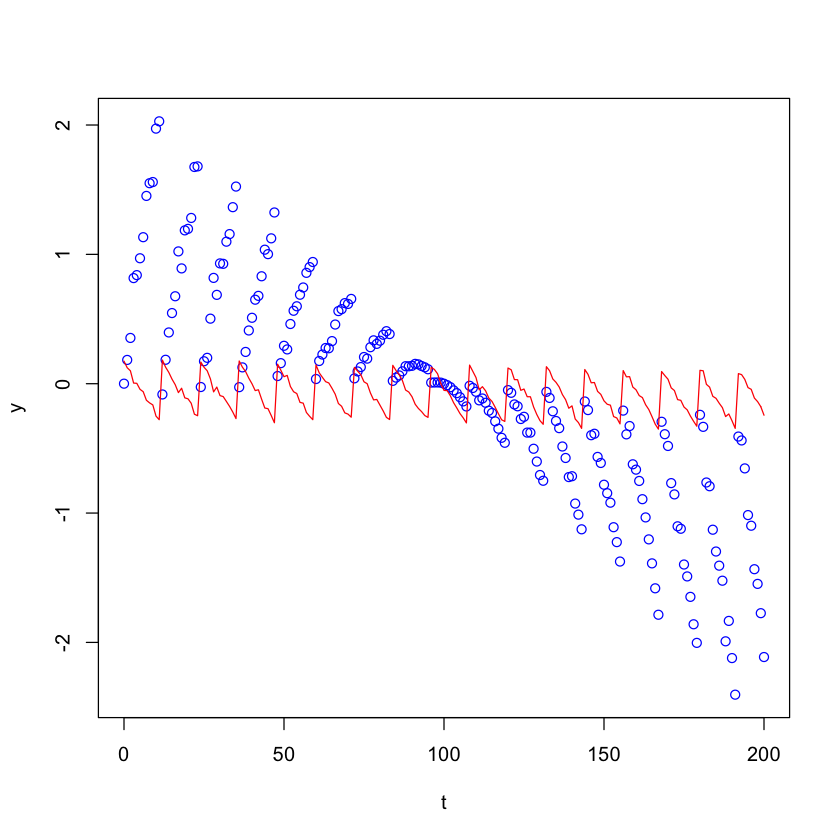

In [12]:
plot(t,y,col='blue') 
points(t,predict(m),type='l',col = 'red')

De blå punkter er observationen og den røde linje er modelens forudsigelse.

#### Kalman filter

Kalmnan filter kan blive brugt til iterativt at opdaterer relationen mellem $x$ og
$y$. Her er state variable coeficienterne $\beta$ og $x_t$ er den kendte $x$ værdi:


$$ y_t = [1 \quad x_t] \beta_t + \nu $$

$$ \beta_{1+t} = I \beta_t + \epsilon $$

Step function må ændres så $H$ kan ændre over tid:

In [13]:
step = function(Kal, measured, x, control_vector=0){
  H = matrix(c(1, x),1,2) 
  with(Kal,{
    #-----------------Prediction step----------------------------- 
    predicted_state_estimate = A %*% x_hat + B %*% control_vector 
    predicted_prob_estimate = (A %*% P_hat) %*% t(A) + Q 
    #-------------------Observation step--------------------------- 
    innovation = measured - H %*% predicted_state_estimate 
    innovation_covariance = H %*% predicted_prob_estimate%*%t(H) + R 
    #-------------------Updatestep------------------------------- 
    kalman_gain = predicted_prob_estimate %*% t(H) %*% solve(innovation_covariance) 
    current_state_estimate = predicted_state_estimate + kalman_gain %*% innovation 
    current_prob_estimate = (diag(1,2)-kalman_gain %*% H) %*% predicted_prob_estimate 
    Kal$x_hat = current_state_estimate 
    Kal$P_hat = current_prob_estimate 
    return(Kal) 
  })
}

Og så den nye kalman list:

In [14]:
Kal = list(A = diag(c(1,1)), 
           B = matrix(0,2,1), 
           x_hat = matrix(1,2,1), 
           P_hat =diag(1,2), 
           Q = diag(c(0.01,0.01)), 
           R = matrix(0.1,1,1))

Så kan det itereres:

In [15]:
n=length(x)
kalman=data.frame(a=rep(NA,n), b=rep(NA,n), y_hat=rep(NA,n))
for (i in 1:n){ 
  kalman[i,1:2] = t(Kal$x_hat) 
  kalman[i,3] = matrix(c(1, x[i]),1,2) %*% Kal$x_hat 
  Kal = step(Kal,y[i],x[i])
}

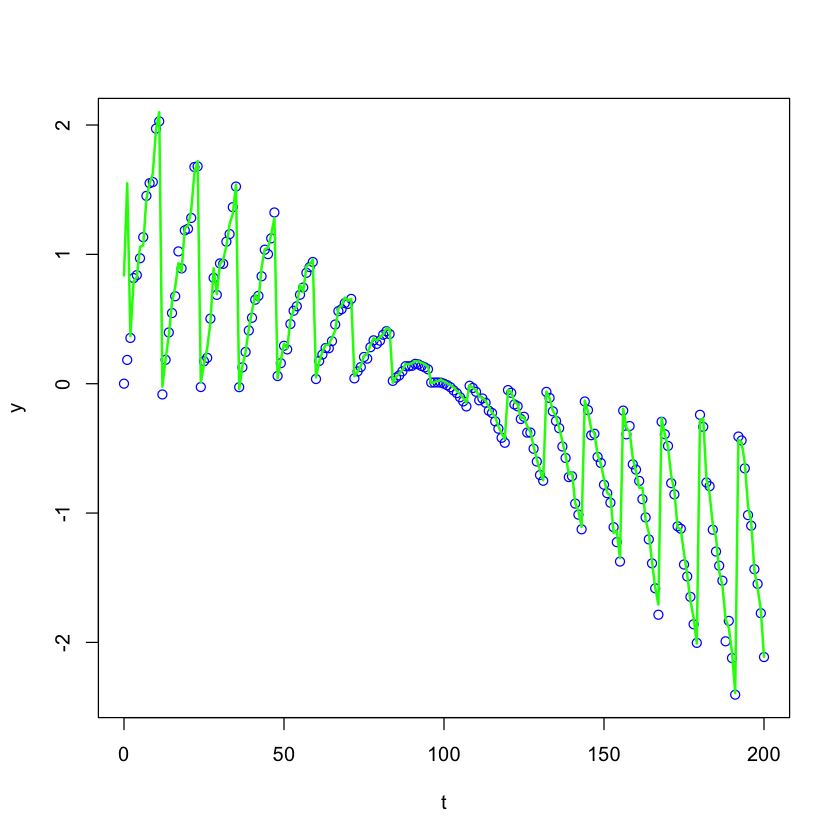

In [16]:
plot(t,y,col='blue') 
points(t,kalman$y_hat,type='l',col='green',lwd=2)

Her er de blå punkter de observerede værdier og den grønne linje er modellens løbede forudsigelse.

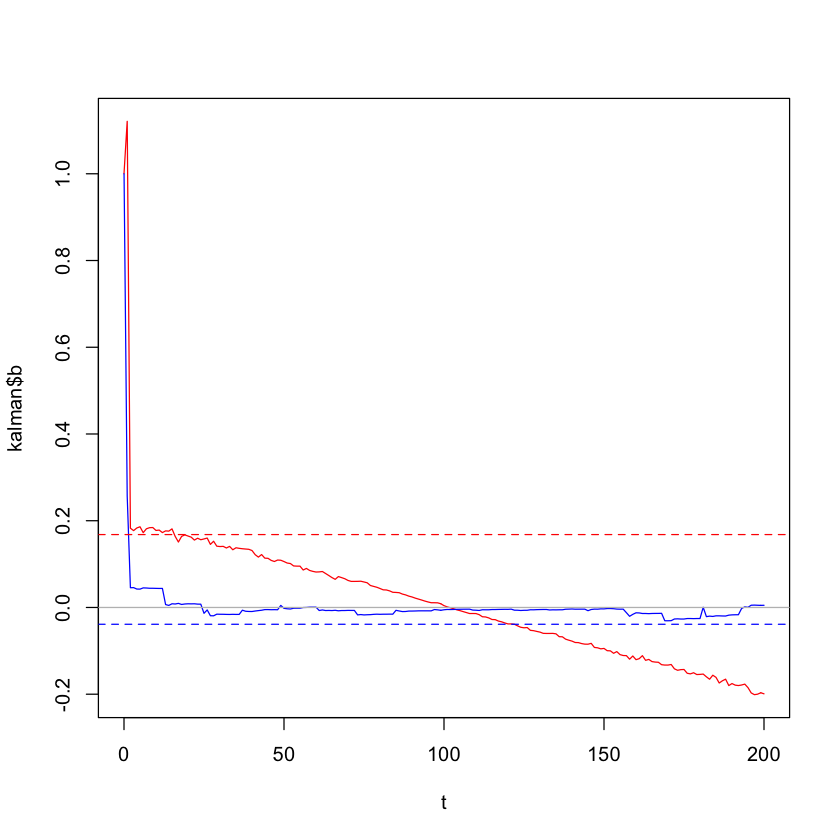

In [17]:
plot(t,kalman$b, type='l',col='red')
points(t,kalman$a, type='l',col='blue') 
abline(h=coef(m)[1],col='red',lty=2) 
abline(h=coef(m)[2],col='blue',lty=2) 
abline(h=0,col='grey')

Her er coeficienterne plottet, skæring blå og hældning rød. De fuldtoptrukne er kalmna filters værdier, til sammeligning er den linære model plottet stiplet.

# Library

Der er adskillige librabry der implementer kalman filter fx KFAS. Detsvære bruges andre symboler, og jeg er ikke helt sikker på jeg har forstået alt rigtig.

In [18]:
library(KFAS)

Yt = matrix(y,n,1) 
Zt = array(rbind(rep(1,n),x),c(1,2,n)) # H
Qt = diag(c(0.01,0.01)) 
Rt = matrix(1,2,2) 
Ht = matrix(0.1,1,1) 
Tt = diag(c(1,1)) 
km = SSModel(y~ -1 + SSMcustom(Z=Zt, R=Rt, T=Tt, Q=Qt)) 

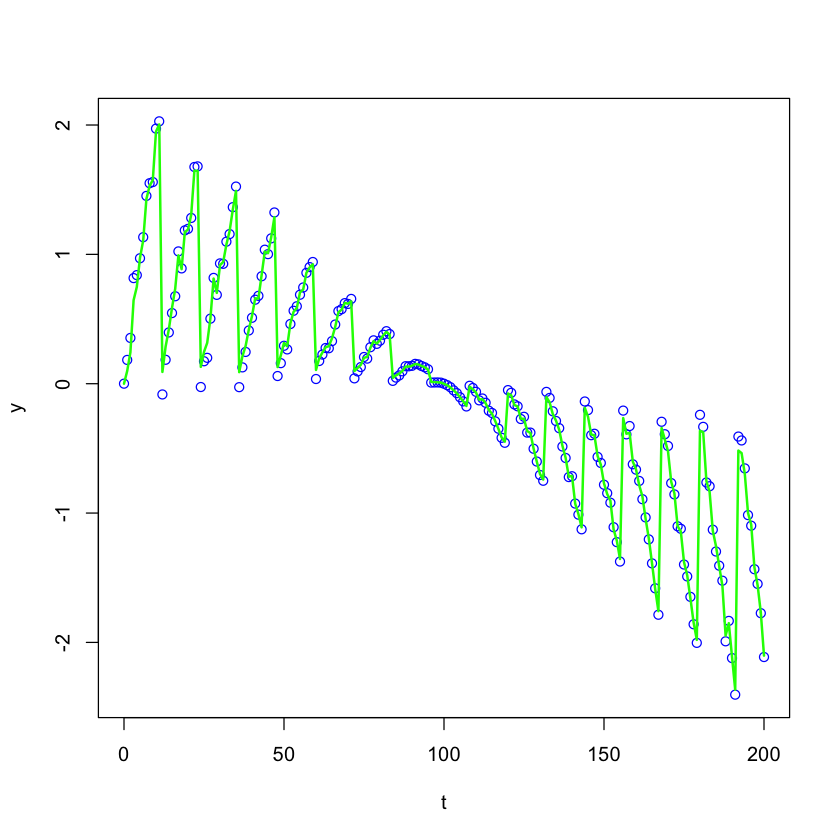

In [19]:
plot(t,y,col='blue') 
points(t,predict(km),col='green', type='l',lwd=2)